In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
!pip install gdown
!gdown --id 1IQ90jtnITrrcBWsFjF8jkFXF7LAxDqLF

In [3]:
%%time
import zipfile
zip_ref = zipfile.ZipFile("archive.zip", 'r')
zip_ref.extractall("./scenery")
zip_ref.close()

CPU times: user 3.38 s, sys: 838 ms, total: 4.22 s
Wall time: 15.3 s


In [4]:
import matplotlib.pyplot as plt
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

In [5]:
import os
IMAGES_PATH="./scenery"
file_names=os.listdir(IMAGES_PATH)
print(f"number of images: {len(file_names)}")

number of images: 4319


In [6]:
import os
import torch
import clip
from os import listdir
from os.path import splitext
import json
from PIL import Image
import pickle as pk
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32")
print(device)
def get_features(image):
    image =  preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features.cpu().numpy()

def generate_clip_features():
    all_image_features=[]
    image_filenames=listdir(IMAGES_PATH)
    try:
       all_image_features=pk.load(open("clip_image_features.pkl", "rb"))
    except (OSError, IOError) as e:
       print("file_not_found")

    def exists_in_all_image_features(image_id):
        for image in all_image_features:
            if image['image_id'] == image_id:
                # print("skipping "+ str(image_id))
                return True
        return False

    def exists_in_image_folder(image_id):
        if image_id in image_filenames:
                return True
        return False   

    def sync_clip_image_features():
        for_deletion=[]
        for i in range(len(all_image_features)):
            if not exists_in_image_folder(all_image_features[i]['image_id']):
                print("deleting "+ str(all_image_features[i]['image_id']))
                for_deletion.append(i)
        for i in reversed(for_deletion):
            del all_image_features[i]

    sync_clip_image_features()
    for image_filename in tqdm(image_filenames):
        image_id=splitext(image_filename)[0]
        if exists_in_all_image_features(image_id):
            continue
        image=Image.open(IMAGES_PATH+"/"+image_filename)
        image_features=get_features(image)
        all_image_features.append({'image_id':image_id,'features':image_features})
    pk.dump(all_image_features, open("clip_image_features.pkl","wb"))


100%|███████████████████████████████████████| 354M/354M [00:07<00:00, 46.4MiB/s]


cuda


In [7]:
generate_clip_features()

  0%|          | 1/4319 [00:00<12:22,  5.81it/s]

file_not_found


100%|██████████| 4319/4319 [02:35<00:00, 27.73it/s]


(1, 512)


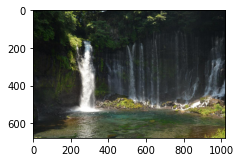

In [8]:
import numpy as np
from PIL import Image
query_image_pillow=Image.open(f'{IMAGES_PATH}/00000061_(6).jpg')
query_image_features=get_features(query_image_pillow)
show_images([np.array(query_image_pillow)])
print(query_image_features.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


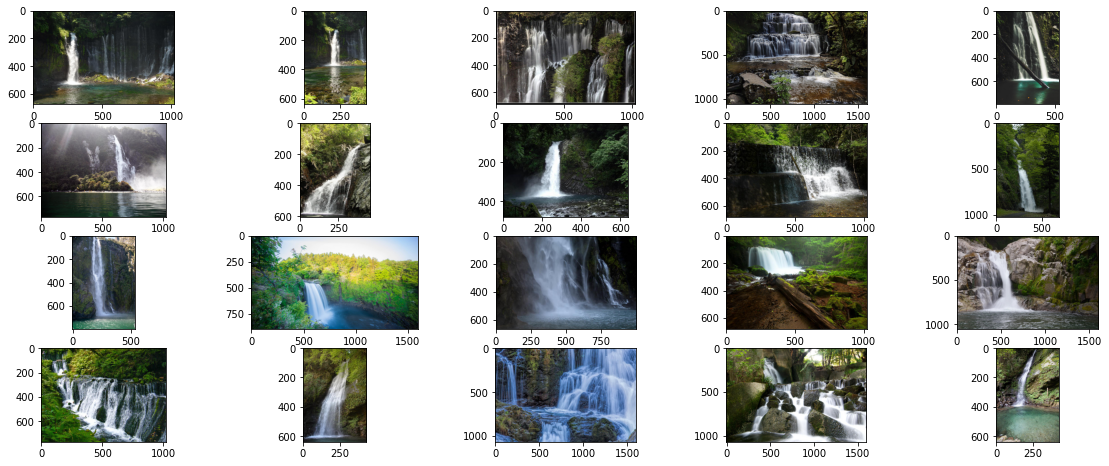

In [9]:
from sklearn.neighbors import NearestNeighbors
from os import listdir
import numpy as np
import pickle as pk
import json
from pathlib import Path

image_features=pk.load( open("clip_image_features.pkl", "rb"))
features=[]
for image in image_features:
    features.append(np.array(image['features']))
features=np.array(features)
features=np.squeeze(features)
# print(features.shape)
# exit()
path="./scenery"
knn = NearestNeighbors(n_neighbors=20,algorithm='brute',metric='euclidean')
knn.fit(features)
file_names=listdir(path)

indices = knn.kneighbors(query_image_features, return_distance=False)
found_images=[]
for x in indices[0]:
    found_images.append(np.array(Image.open(path+"/"+file_names[x])))
show_images(np.array(found_images))

In [ ]:
!pip install hnswlib

In [23]:
import hnswlib
dim=512
index = hnswlib.Index(space='l2', dim=dim)
index.init_index(max_elements=10000, ef_construction=100, M=16)
index.add_items(features)

In [24]:
%%time
labels, distances = index.knn_query(query_image_features, k = 20)

CPU times: user 399 µs, sys: 25 µs, total: 424 µs
Wall time: 266 µs


[2580 2634 2338  683 2583  620 3342   85 1961 2368  780 3349 2847 3605
 2052 2468 2191 3959 3431  804]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


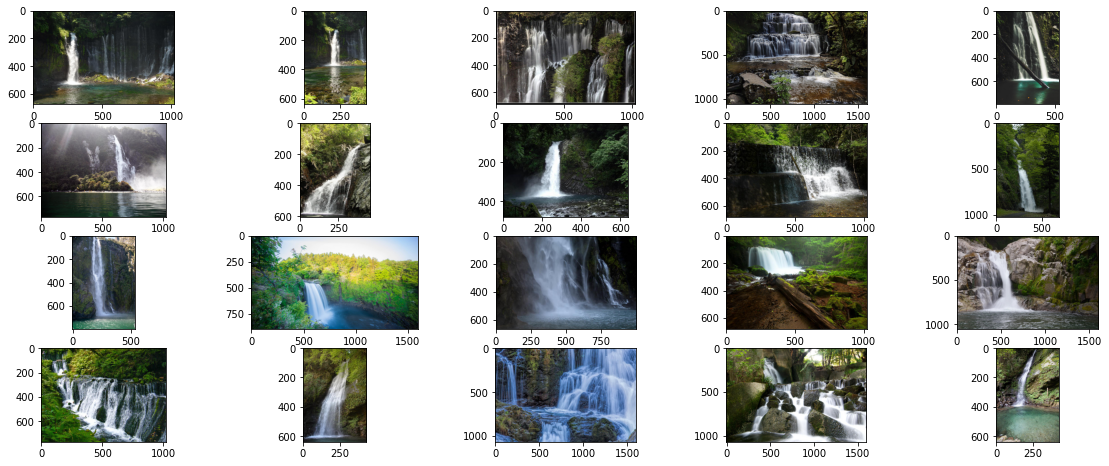

In [25]:
images_np_hnsw=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw.append(np.array(Image.open(f'{IMAGES_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw))

[3706  374 3824 3911 3431 2121 2583  286 1616 3415  701 2637 1161 3714
 1932 2752  548  483 2629  118]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


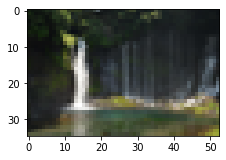

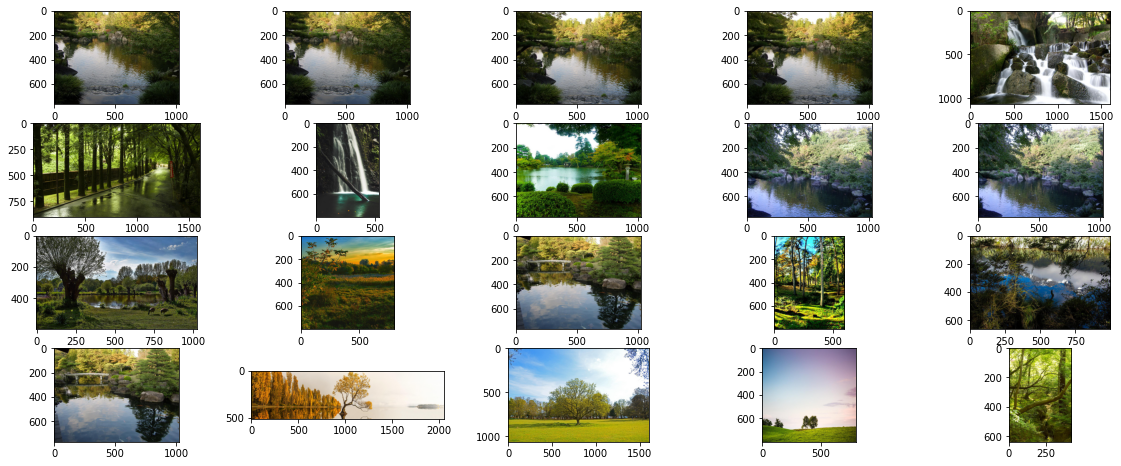

In [26]:
width, height = query_image_pillow.size
query_image_resized=query_image_pillow.resize((width//19, height//19))
query_image_resized_features=get_features(query_image_resized)
show_images([np.array(query_image_resized)])
labels, distances = index.knn_query(query_image_resized_features, k = 20)
images_np_hnsw_2=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw_2.append(np.array(Image.open(f'{IMAGES_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw_2))

[2634 2580 2583 2266 3959 2338  382 3342  780 2847 2368 2191 1058 1961
  683 2052 4271  764 1776 3602]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


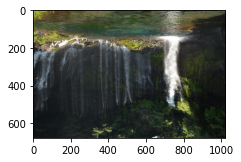

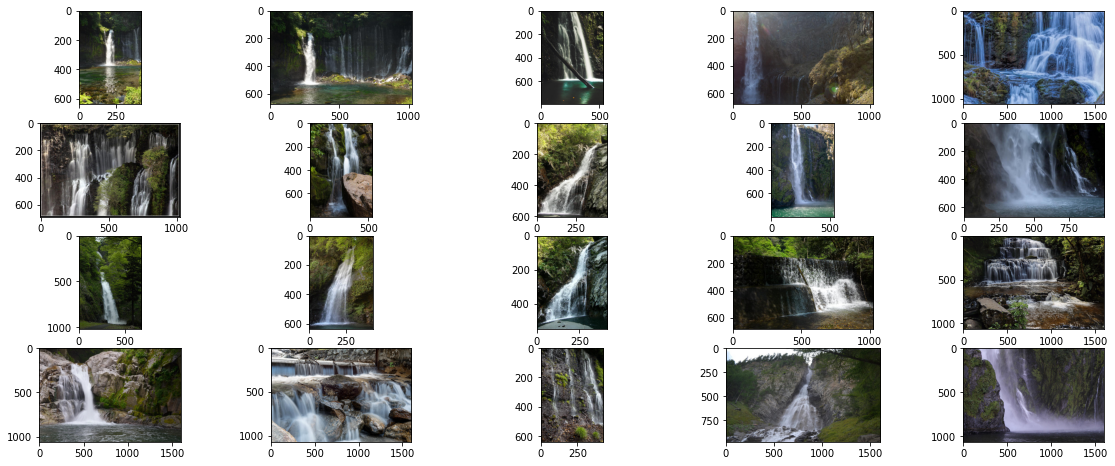

In [27]:
query_image_rotated = query_image_pillow.rotate(180)
query_image_rotated_features=get_features(query_image_rotated)
show_images([np.array(query_image_rotated)])
labels, distances = index.knn_query(query_image_rotated_features, k = 20)
images_np_hnsw_3=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw_3.append(np.array(Image.open(f'{IMAGES_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw_3))

[2847 2634  355 2580 2583 2266 2191 2338 3959 2368  683 4271  780  382
  764 3254 3431 1058 2923 2463]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


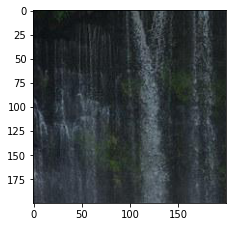

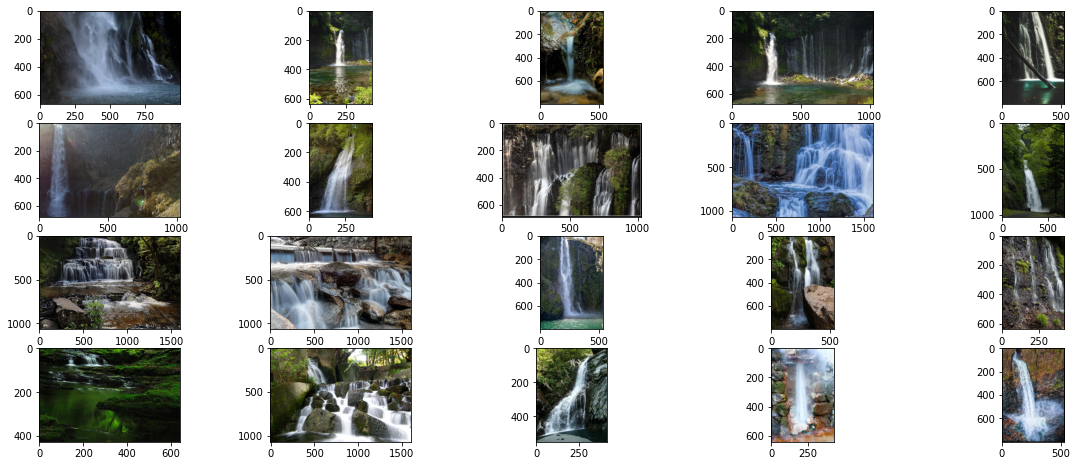

In [28]:
crop_rectangle = (400, 200, 600, 400)
query_image_cropped = query_image_pillow.crop(crop_rectangle)
query_image_cropped_features=get_features(query_image_cropped)
show_images([np.array(query_image_cropped)])
labels, distances = index.knn_query(query_image_cropped_features, k = 20)
images_np_hnsw_4=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw_4.append(np.array(Image.open(f'{IMAGES_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw_4))

In [20]:
text_tokenized = clip.tokenize(["a picture of a windows xp wallpaper"]).to(device)
with torch.no_grad():
        text_features = model.encode_text(text_tokenized)
        text_features /= text_features.norm(dim=-1, keepdim=True)

In [21]:
%%time
labels, distances = index.knn_query(text_features.cpu().numpy(), k = 20)

CPU times: user 422 µs, sys: 0 ns, total: 422 µs
Wall time: 436 µs


[  91 3838 1463 2132  851 1602 1764 3439 4208 1087 4169 4189 2986 4292
 4024 1284 2107 4314 1933 1910]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


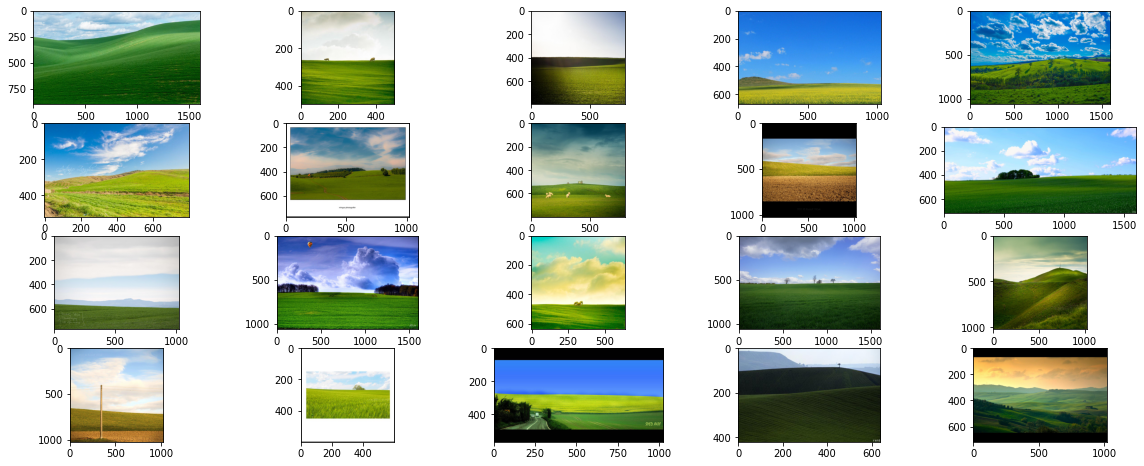

In [22]:
images_np_hnsw_clip_text=[]
labels=labels[0]
print(labels)
for idx in labels:
  images_np_hnsw_clip_text.append(np.array(Image.open(f'{IMAGES_PATH}/{file_names[idx]}')))
show_images(np.array(images_np_hnsw_clip_text))

In [ ]:
!pip install git+https://github.com/qwertyforce/Embeddings2Image.git@patch-1

In [18]:
import os
from tqdm import tqdm
from e2i import EmbeddingsProjector
import numpy as np
import h5py
import pickle as pk
data_path = 'data.hdf5'
output_path = 'output_plot'
full_file_names=list(map(lambda el: IMAGES_PATH+"/"+el,file_names))
with h5py.File(data_path, 'w') as hf:
    hf.create_dataset('urls', data=np.asarray(full_file_names).astype("S"))
    hf.create_dataset('vectors', data=features)
    hf.close()

In [19]:
image = EmbeddingsProjector()
image.path2data = data_path
image.load_data()
image.each_img_size = 100
image.output_img_size =  10000
image.calculate_projection()
image.output_img_name = output_path
image.output_img_type = 'scatter'
image.create_image()
print(image.image_list)
print('done!')

dimension reduction using svd
dimension before: 512
dimension after: 50


100%|██████████| 4319/4319 [00:55<00:00, 77.93it/s]


['./scenery/00000230_(2).jpg', './scenery/00000512_(2).jpg', './scenery/00000200_(6).jpg', './scenery/00000802.jpg', './scenery/00000343_(4).jpg', './scenery/00000839_(3).jpg', './scenery/00000036_(3).jpg', './scenery/00000129_(2).jpg', './scenery/00000844_(2).jpg', './scenery/00000198_(2).jpg', './scenery/00000030.jpg', './scenery/00000232_(3).jpg', './scenery/00000002_(6).jpg', './scenery/00000311_(6).jpg', './scenery/00000388_(2).jpg', './scenery/00000265_(5).jpg', './scenery/00000251_(4).jpg', './scenery/00000290_(3).jpg', './scenery/00000241_(2).jpg', './scenery/00000282.jpg', './scenery/00000591_(4).jpg', './scenery/00000092_(2).jpg', './scenery/00000405.jpg', './scenery/00000481.jpg', './scenery/00000220_(4).jpg', './scenery/00000297.jpg', './scenery/00000182_(5).jpg', './scenery/00000392_(3).jpg', './scenery/00000047_(4).jpg', './scenery/00000464_(4).jpg', './scenery/00000832.jpg', './scenery/00000173_(3).jpg', './scenery/00000211_(3).jpg', './scenery/00000400_(5).jpg', './scen